In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('churn_bank.csv')
NRows, NColumns = df.shape

### Transforming the database

In [2]:
# convert all variables to their most appropriate type
df = df.convert_dtypes()
df.dtypes
# we can clearly see which variables to change or "dummify": exited, geography and gender

CustomerId                  Int64
Surname            string[python]
CreditScore                 Int64
Geography          string[python]
Gender             string[python]
Age                         Int64
Tenure                      Int64
Balance                   Float64
NumOfProducts               Int64
HasCrCard                   Int64
IsActiveMember              Int64
EstimatedSalary           Float64
Exited                      Int64
dtype: object

In [3]:
# Y variable => to float
df['Exited'] = df['Exited'].astype("float")

# Dummy gender: female = 1, male = 0
df["Gender"] = (df["Gender"] == "Female").astype(int)

# 3 dummy variables for geography
# Making sure the last column is still exit for separating easily later
df.insert(NColumns-1, 'InSpain', (df["Geography"] == "Spain").astype(int))
df.insert(NColumns-1, 'InFrance', (df["Geography"] == "France").astype(int))
df.insert(NColumns-1, 'InGermany', (df["Geography"] == "Germany").astype(int))


In [4]:
# deleting variables we do not care about
df = df.drop(["CustomerId", "Surname", "Geography"], axis=1)

In [5]:
# making sure all values are numeric
df.dtypes

CreditScore          Int64
Gender               int64
Age                  Int64
Tenure               Int64
Balance            Float64
NumOfProducts        Int64
HasCrCard            Int64
IsActiveMember       Int64
EstimatedSalary    Float64
InGermany            int64
InFrance             int64
InSpain              int64
Exited             float64
dtype: object

### Building a tree and analysing its performance

In [23]:
# importing scickit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

In [7]:
# preparing X and Y
df_Y = df[['Exited']]
df_X = df[df.columns[:NColumns-1]]

In [8]:
# dividing into train and test
df_X_train, df_X_test, df_Y_train, df_Y_test = train_test_split(df_X,
df_Y,
test_size=0.3,
random_state=0,
stratify=df_Y)

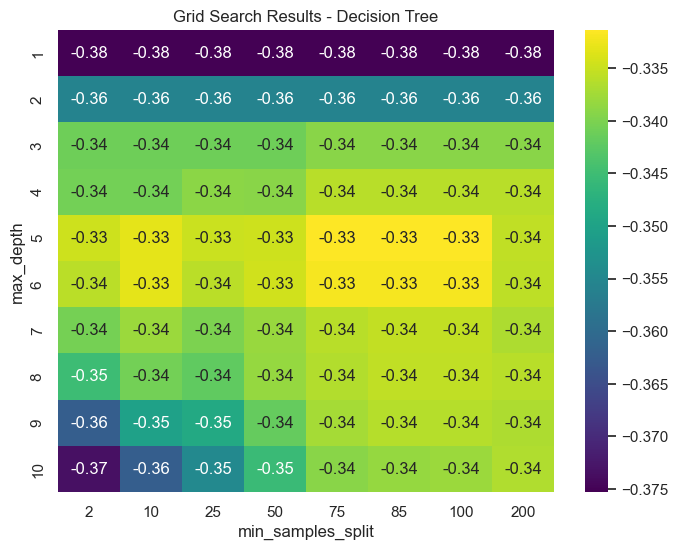

Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 75}
0.3353205916138877


In [22]:
# Creating our grid search based on the RMSE metric

# prepping for GridSearchCV
v_split = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=0)
tree = DecisionTreeRegressor(random_state=0)
param_grid = {'max_depth': range(1, 11),
              'min_samples_split': [2, 10, 25, 50, 75, 85, 100, 200]}

tree_search = GridSearchCV(tree, param_grid, cv=v_split, n_jobs = -1,
                         scoring = "neg_root_mean_squared_error")

# we fit it to out data
tree_res = tree_search.fit(df_X_train, df_Y_train)

#we plot the grid to see the optimal parameter combination
df = pd.DataFrame(tree_res.cv_results_['params'])
df['mean_test_score'] = tree_res.cv_results_['mean_test_score']
sns.set_theme()
sns.set(rc={'figure.figsize': (8, 6)})
sns.heatmap(df.pivot_table(index='max_depth', columns='min_samples_split',
values='mean_test_score'),
cmap='viridis', annot=True)
plt.title('Grid Search Results - Decision Tree')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.show()

# Get the best hyperparameters
best_params = tree_search.best_params_

# Get the best model
best_model = tree_search.best_estimator_

# we predict the test and observe the RMSE
print(f"Best Hyperparameters: {best_params}")
print(root_mean_squared_error(df_Y_test, tree_res.predict(df_X_test)))

A RMSE value of 0.33 means that our model can more or less predict the data. However, it would be interesting to see if a bigger database than ours would improve the prediction of the model since ours would be considered small for a machine learning algorythm. 

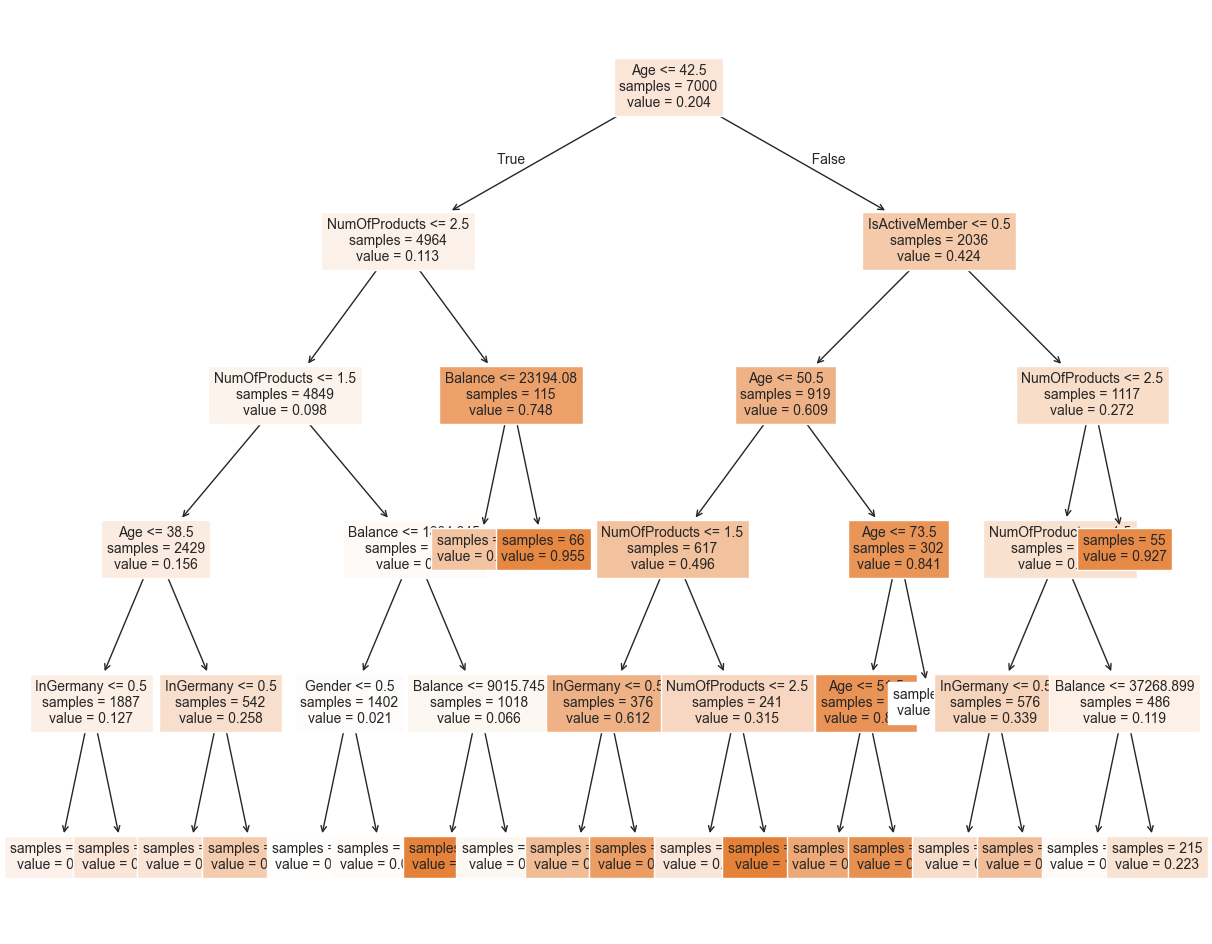

In [41]:
# visualize the tree to see the determining factors
tree = DecisionTreeRegressor(min_samples_split=best_params["min_samples_split"],
                              max_depth = best_params["max_depth"])
tree.fit(df_X_train,df_Y_train)

column_names = df_X.columns.values.tolist()

plt.figure(figsize=(15,12))  # set plot size (denoted in inches)
plot_tree(tree, fontsize=10, feature_names=column_names, filled=True, impurity=False, proportion = False)
plt.show()